In [2]:
import pickle

import numpy as np


def load_data(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# Replace 'filtered_gino.pkl' with your file paths
gino_data = load_data('filtered_gino.pkl')
koly1_data = load_data('filtered_koly1.pkl')
koly2_data = load_data('filtered_koly2.pkl')


from scipy.spatial.distance import euclidean
import numpy as np


In [3]:
import numpy as np

def flatten_data(data_dict):
    # Determine the maximum length of any sequence in the dataset
    max_length = max(array.size for array in data_dict.values())
    
    # Flatten and pad data
    flattened_data = []
    for key, array in data_dict.items():
        # Flatten array
        flat_array = array.reshape(-1)
        # Pad array if necessary
        if flat_array.size < max_length:
            flat_array = np.pad(flat_array, (0, max_length - flat_array.size), 'constant')
        flattened_data.append(flat_array)
    return flattened_data


gino_flattened = flatten_data(gino_data)
koly1_flattened = flatten_data(koly1_data)
koly2_flattened = flatten_data(koly2_data)


In [4]:
from sklearn.decomposition import PCA

def apply_pca(data, n_components=10):
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)
    return reduced_data

gino_reduced = apply_pca(gino_flattened)
koly1_reduced = apply_pca(koly1_flattened)
koly2_reduced = apply_pca(koly2_flattened)

from sklearn.cluster import KMeans

def apply_kmeans(data, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(data)
    return labels

gino_labels = apply_kmeans(gino_reduced)
koly1_labels = apply_kmeans(koly1_reduced)
koly2_labels = apply_kmeans(koly2_reduced)


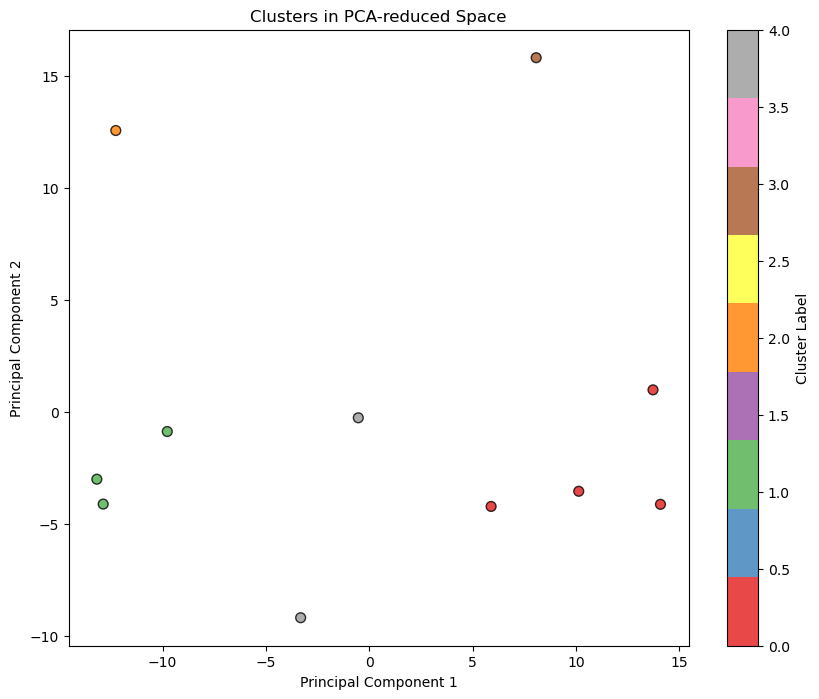

In [5]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_clusters(data, labels, title='Clusters in PCA-reduced Space'):
    # Create a scatter plot with clusters shown in different colors
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='Set1', marker='o', edgecolor='k', s=50, alpha=0.8)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    plt.show()

# Assuming gino_reduced contains the PCA-reduced data and gino_labels contains the cluster labels
plot_clusters(gino_reduced, gino_labels)



## Read frame indices and plot video

In [6]:
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Function to load data from a pickle file
def load_data(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# Function to infer frame indices
def infer_frame_indices(data_dict):
    current_frame = 0
    frame_indices = {}
    for key, segment in data_dict.items():
        n_frames = segment.shape[0]
        frame_indices[key] = (current_frame, current_frame + n_frames - 1)
        current_frame += n_frames
    return frame_indices
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip

import cv2
import numpy as np
from moviepy.editor import VideoFileClip, VideoClip


def add_text_with_opencv(frame, text, position, font_scale, color):
    # Ensure the frame is in uint8, and copy it to reset any problematic flags
    frame = np.array(frame, dtype=np.uint8).copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Apply the text
    cv2.putText(frame, text, position, font, font_scale, color, 2, cv2.LINE_AA)
    return frame

def annotate_video(input_path, output_path, labels, frame_indices, fps):
    # Load the video
    clip = VideoFileClip(input_path)
    
    # Function to modify frames
    def make_frame(t):
        frame = clip.get_frame(t)
        # Convert RGB to BGR, as OpenCV uses BGR
        frame_bgr = frame[:, :, ::-1]
        # Loop through each segment to check if we should draw a label
        for key, (start, end) in frame_indices.items():
            if start / fps <= t < end / fps:
                label = labels[int(key.split('_')[1])]
                color = (0, 255, 0) if label == 0 else (0, 0, 255)  # Green for label 0, Red otherwise
                frame_bgr = add_text_with_opencv(frame_bgr, str(label), (50, 50), 1, color)
        # Convert back to RGB
        return frame_bgr[:, :, ::-1]

    # Create a video clip with the modified frames
    annotated_clip = VideoClip(make_frame, duration=clip.duration)
    import pdb; pdb.set_trace()
    #import pdb; pdb.set_trace()
    annotated_clip.set_fps(fps).write_videofile(output_path, codec='libx264')

def get_video_fps(video_path):
    with VideoFileClip(video_path) as video:
        fps = video.fps
    return fps

# Load data and infer frames
data = load_data('filtered_gino.pkl')
frame_indices = infer_frame_indices(data)

# Assume you have labels and video path
video_path = 'gino.mp4'
fps = get_video_fps(video_path)  # Retrieve fps using the function defined earlier
output_path = 'gino_labeled.mp4'
# Add labels to the video
#annotate_video(video_path, output_path, labels, frame_indices, fps)


In [7]:
from IPython.display import display, clear_output
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
import ipywidgets as widgets

from IPython.display import display, clear_output
import cv2
from moviepy.editor import VideoFileClip
import ipywidgets as widgets
import numpy as np

def save_annotated_video(input_path, output_path, labels, frame_indices):
    clip = VideoFileClip(input_path)
    fps = clip.fps

    def make_frame(t):
        frame = clip.get_frame(t)
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV

        # Apply text annotations based on the frame time and indices
        for key, (start, end) in frame_indices.items():
            if start / fps <= t < end / fps:
                label_idx = int(key.split('_')[1])  # Extract the numeric index from key 'chop_x'
                label = labels[label_idx]
                color = (0, 255, 0) if label == 0 else (255, 0, 0)  # Simple color assignment
                cv2.putText(frame_bgr, str(label), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

        return cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)  # Convert BGR back to RGB for moviepy

    # Create a video clip with the modified frames
    annotated_clip = VideoClip(make_frame, duration=clip.duration)
    annotated_clip.set_fps(fps).write_videofile(output_path, codec='libx264')
    clip.close()



In [1]:
'hi'

'hi'

In [48]:
def play_annotated_video_in_notebook(input_path, labels, frame_indices):
    clip = VideoFileClip(input_path)
    fps = clip.fps  # Ensure we capture the frames per second of the video

    output = widgets.Output()  # Create an output widget for displaying video frames
    display(output)  # Display this widget

    # Iterate through video frames and display them with annotations
    for frame_time, frame in clip.iter_frames(fps=fps, with_times=True):
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV

        # Ensure the frame is in uint8 format
        if frame_bgr.dtype != np.uint8:
            frame_bgr = np.array(frame_bgr, dtype=np.uint8)

        # Apply text annotations based on the frame time and indices
        for key, (start, end) in frame_indices.items():
            if start / fps <= frame_time < end / fps:
                label_idx = int(key.split('_')[1])  # Assuming keys are 'chop_x'
                label = labels[label_idx]  # Get the label for this segment from the clustering results
                color = (0, 255, 0) if label == 0 else (255, 0, 0)  # Choose color based on label
                cv2.putText(frame_bgr, str(label), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)  # Convert back to RGB for display

        # Display the frame in the notebook
        with output:
            clear_output(wait=True)
            display(widgets.Image(value=cv2.imencode('.png', frame_rgb)[1].tobytes()))

    clip.close()



#play_annotated_video_in_notebook(video_path, gino_labels, frame_indices)

Output()

In [12]:
import cv2
import numpy as np

def save_annotated_video(input_path, output_path, labels, frame_indices, fps):
    # Open the input video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise IOError("Cannot open video")

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define the codec and create VideoWriter object to write the video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change 'mp4v' to 'XVID' if there are issues
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Break the loop if there are no frames to read

        # Process each frame and apply annotations
        for key, (start, end) in frame_indices.items():
            if start <= frame_count < end:
                label = labels[int(key.split('_')[1])]
                color = (0, 255, 0) if label == 0 else (255, 0, 0)
                cv2.putText(frame, str(label), (150, 150), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)  # Double large font
        # Write the frame into the file 'output_path'
        out.write(frame)
        frame_count += 1

    # Release everything when the job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print("Video saved successfully!")



save_annotated_video(video_path, output_path, gino_labels, frame_indices, fps)


Video saved successfully!
